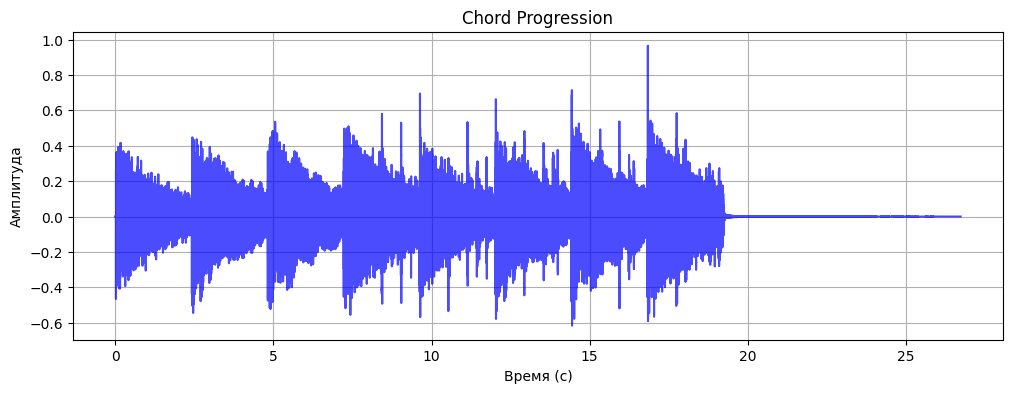

In [24]:
import librosa
import IPython.display as ipd

from src.plot import plot_audio_signal


CHORD_PROGRESSION_PATH = "audio/progression.mp3"

progression_y, sr = librosa.load(CHORD_PROGRESSION_PATH)

plot_audio_signal(y=progression_y, sr=sr, title="Chord Progression")
ipd.Audio(progression_y, rate=sr)

### Спектрограмма

Спектрограмма — это график, который показывает, как меняется частотный состав аудио во времени. По горизонтали — время, по вертикали — частоты, а яркость или цвет отражает громкость частоты.

На спектрограмме чётко видны отдельные ноты или звуки, что позволяет легко определить, какие именно ноты звучат в аккорде, проанализировать мелодию или обнаружить шумы и искажения в сигнале.


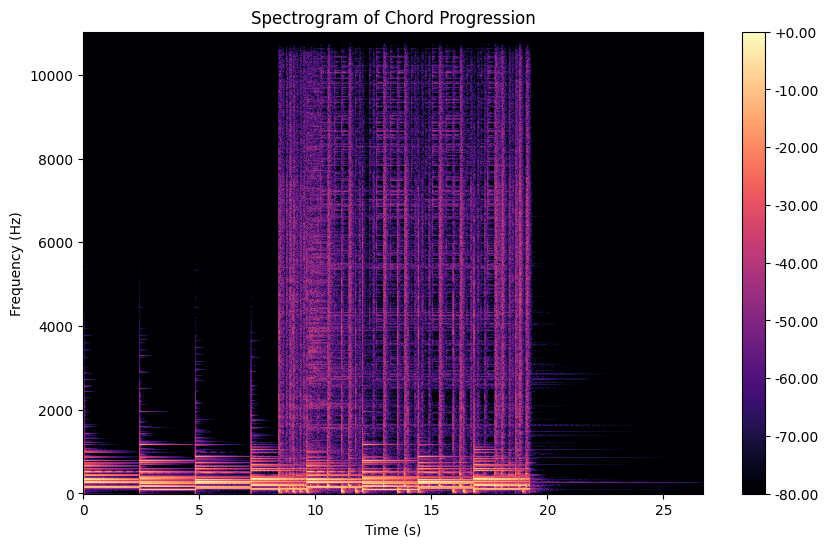

In [25]:
import matplotlib.pyplot as plt
import numpy as np

S = librosa.stft(progression_y)
S_abs = np.abs(S)
S_db = librosa.amplitude_to_db(S_abs, ref=np.max)

plt.figure(figsize=(10, 6))
librosa.display.specshow(S_db, sr=sr, x_axis="time", y_axis="hz")
plt.colorbar(format='%+0.2f')

plt.title("Spectrogram of Chord Progression")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.show()

ipd.display(ipd.Audio(progression_y, rate=sr))


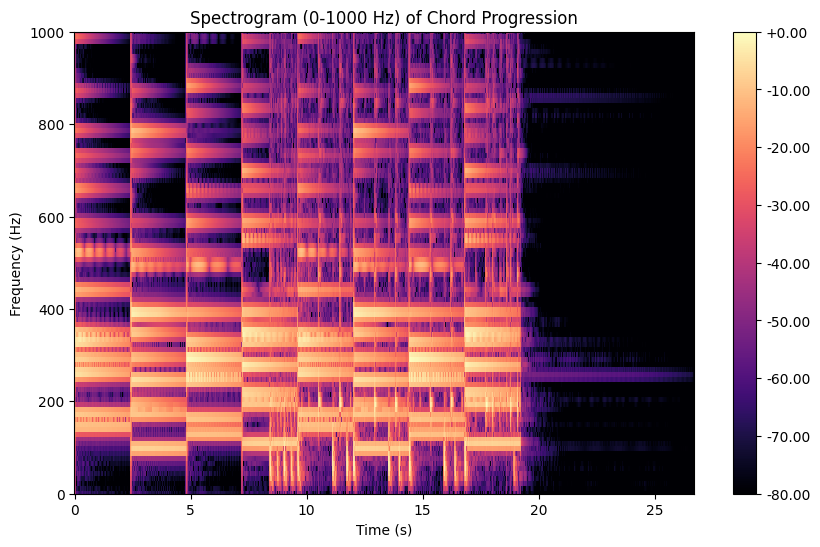

In [26]:
plt.figure(figsize=(10, 6))
librosa.display.specshow(S_db, sr=sr, x_axis="time", y_axis="hz")
plt.colorbar(format='%+0.2f')

plt.ylim(0, 1000)

plt.title("Spectrogram (0-1000 Hz) of Chord Progression")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.show()

ipd.display(ipd.Audio(progression_y, rate=sr))


**Спектрограмма** — это визуализация частотного состава сигнала, которая показывает, как меняется спектр сигала со временем. Чем ярче цвет на спектрограмме, тем больше амплитуда (или «громкость») данной частоты в этот момент времени.

**Как она строится?**  
1. Аудиосигнал делится на короткие интервалы времени (окна).
2. Для каждого такого окна считается преобразование Фурье.
3. Результат выводится в виде тепловой карты:
- по горизонтали (ось X) — время,
- по вертикали (ось Y) — частота,
- цвет (яркость) — сила (амплитуда или энергия).

**Как анализировать спектрограмму:**
- Вертикальные полосы — аккорды или ноты, которые звучат в данный момент.
- Смена аккордов — это изменения вертикальных «узоров» на спектрограмме.
- Чем ярче цвет на конкретной частоте и времени, тем сильнее выражена эта частота в сигнале.

**Применение спектрограммы:**
- Позволяет отслеживать изменения гармонического состава музыки во времени.
- Удобно для анализа музыки, распознавания аккордов, сегментации аудио и анализа тембра инструментов.

Так ты получаешь наглядный инструмент анализа аудиосигналов, который помогает слушателю «увидеть», как меняются аккорды и ноты в течение всего трека.

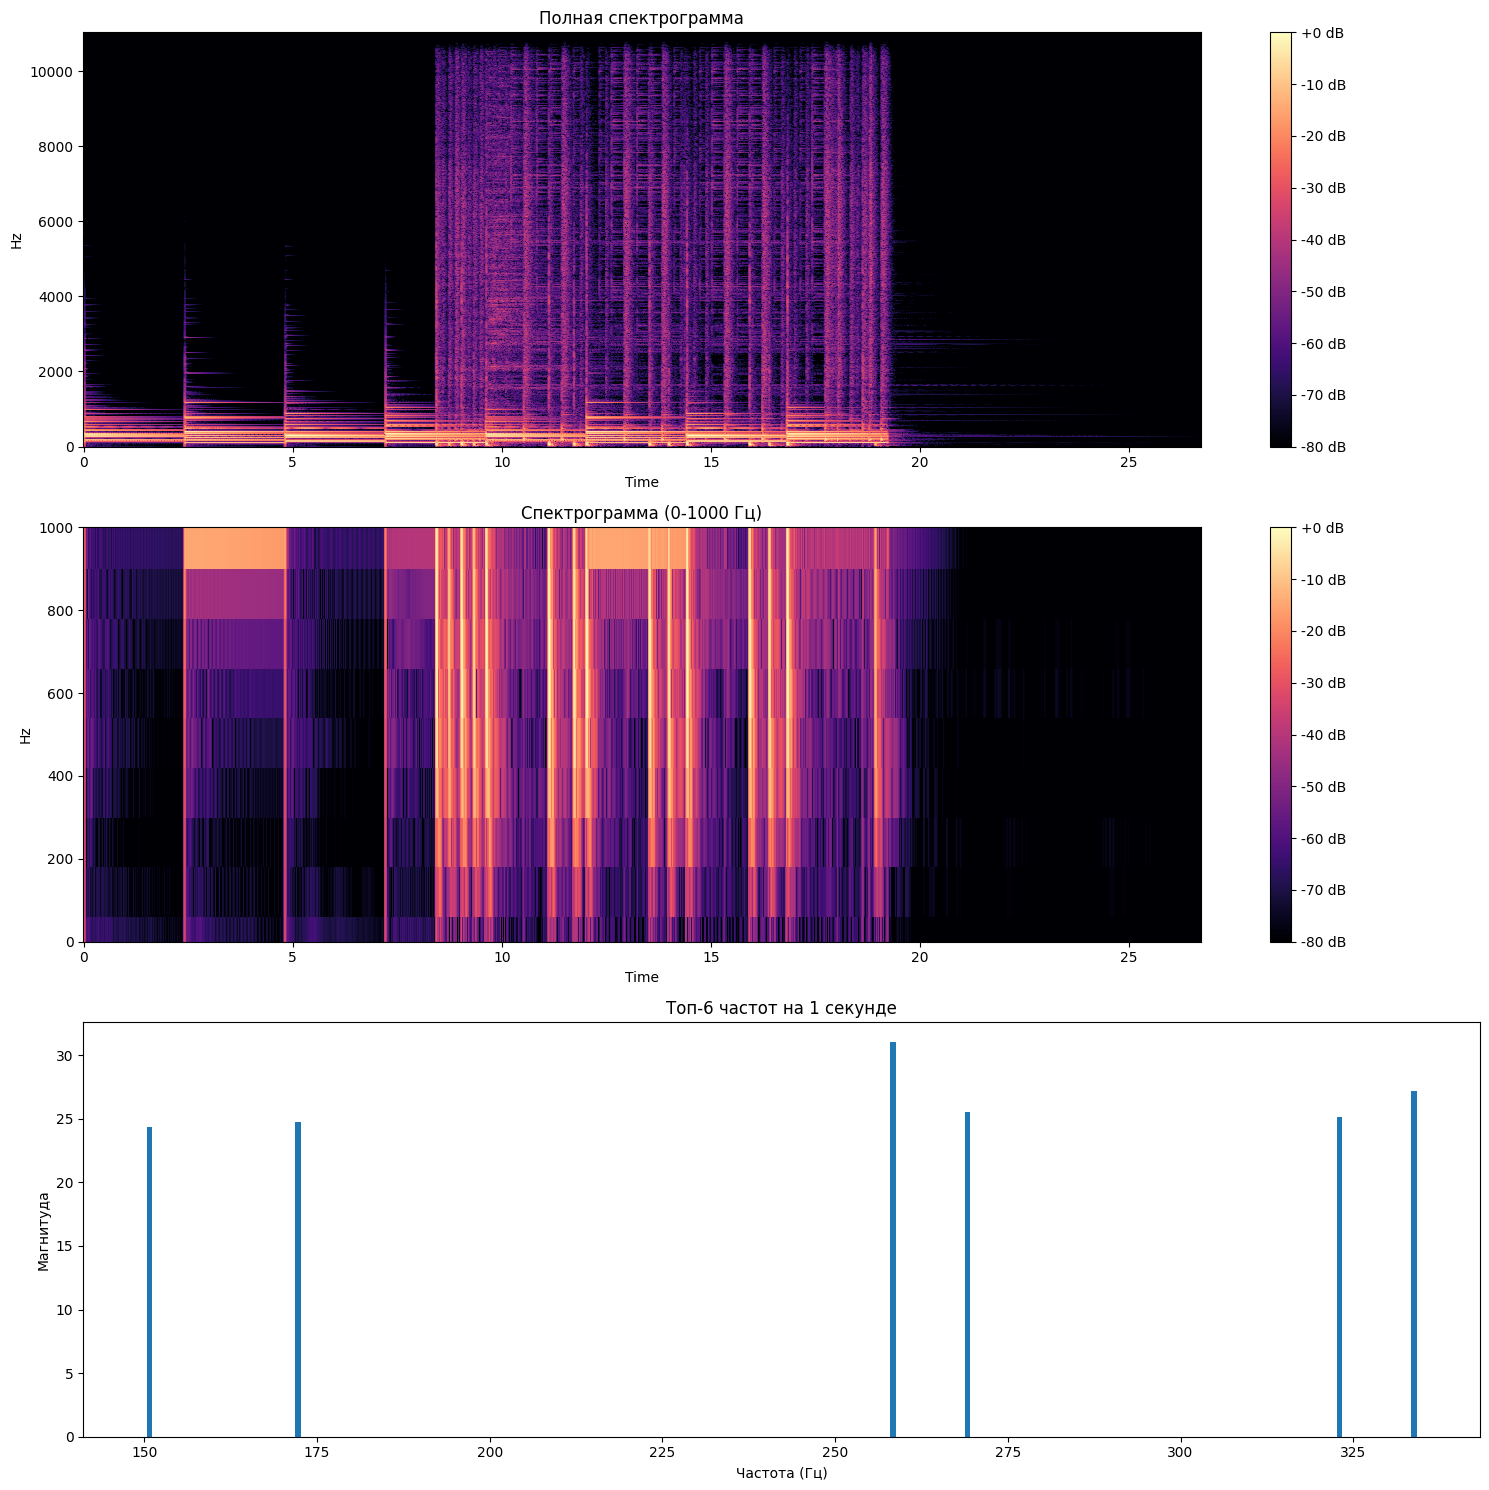

Доминантные частоты на 1 секунде:
Частота: 258.40 Гц, Магнитуда: 31.0271
Частота: 333.76 Гц, Магнитуда: 27.1882
Частота: 269.17 Гц, Магнитуда: 25.5669
Частота: 323.00 Гц, Магнитуда: 25.1589
Частота: 172.27 Гц, Магнитуда: 24.7645
Частота: 150.73 Гц, Магнитуда: 24.3819


In [27]:
def analyze_audio_spectrogram(file_path: str) -> dict[str, str | float]:
    audio_data, sample_rate = librosa.load(file_path, mono=True)
    
    # Параметры STFT
    n_fft = 2048
    hop_length = 512
    
    # Вычисление полной спектрограммы
    D = librosa.stft(audio_data, n_fft=n_fft, hop_length=hop_length)
    D_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    
    # Вычисление частот
    frequencies = librosa.fft_frequencies(sr=sample_rate, n_fft=n_fft)
    
    # Выделение частот до 1000 Гц
    freq_mask = frequencies <= 1000
    D_limited = D[freq_mask, :]
    D_limited_db = librosa.amplitude_to_db(np.abs(D_limited), ref=np.max)
    frequencies_limited = frequencies[freq_mask]
    
    # Вычисление временных отметок
    times = librosa.times_like(D, sr=sample_rate, hop_length=hop_length)
    
    plt.figure(figsize=(15, 15))
    
    # Полная спектрограмма
    plt.subplot(3, 1, 1)
    librosa.display.specshow(D_db, sr=sample_rate, x_axis='time', y_axis='hz')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Полная спектрограмма')
    
    # Спектрограмма до 1000 Гц
    plt.subplot(3, 1, 2)
    librosa.display.specshow(D_limited_db, sr=sample_rate, x_axis='time', y_axis='hz')
    plt.ylim(0, 1000)
    plt.colorbar(format='%+2.0f dB')
    plt.title('Спектрограмма (0-1000 Гц)')
    
    # Анализ доминантных частот на 1 секунде
    def extract_top_frequencies(spectrogram, frequencies, time_index, top_n=6):
        time_slice = np.abs(spectrogram[:, time_index])
        top_indices = np.argsort(time_slice)[::-1][:top_n]
        return frequencies[top_indices], time_slice[top_indices]
    
    # Найти ближайший индекс времени к 1 секунде
    time_index = np.argmin(np.abs(times - 1.0))
    
    # Извлечение топ-частот для ограниченного диапазона
    top_freqs, top_magnitudes = extract_top_frequencies(
        D_limited, frequencies_limited, time_index
    )
    
    # График доминантных частот на 1 секунде
    plt.subplot(3, 1, 3)
    plt.bar(top_freqs, top_magnitudes)
    plt.title(f'Топ-{len(top_freqs)} частот на 1 секунде')
    plt.xlabel('Частота (Гц)')
    plt.ylabel('Магнитуда')
    
    plt.tight_layout()
    plt.show()
    
    return {
        'full_spectrogram': D_db,
        'limited_spectrogram': D_limited_db,
        'top_frequencies': top_freqs,
        'top_magnitudes': top_magnitudes
    }

# Пример использования
results = analyze_audio_spectrogram("/home/gio/code/audio_course/audio/progression.mp3")

# Вывод доминантных частот
print("Доминантные частоты на 1 секунде:")
for freq, mag in zip(results['top_frequencies'], results['top_magnitudes']):
    print(f"Частота: {freq:.2f} Гц, Магнитуда: {mag:.4f}")

In [28]:
for freq in results["top_frequencies"]:
    print(freq)
    print(librosa.hz_to_note(freq))

258.3984375
C4
333.7646484375
E4
269.1650390625
C4
322.998046875
E4
172.265625
F3
150.732421875
D3


In [ ]:
from scipy.cluster.hierarchy import fcluster, linkage


def cluster_frequencies(frequencies, magnitudes, threshold=20):
    """
    Кластеризация близких частот с сохранением максимальной магнитуды
    
    Параметры:
    -----------
    frequencies : array
        Массив частот
    magnitudes : array  
        Массив магнитуд
    threshold : float
        Порог для объединения частот
    
    Возвращает:
    -----------
    tuple: Очищенные частоты и магнитуды
    """
    # Преобразование частот в матрицу для кластеризации
    X = frequencies.reshape(-1, 1)
    
    # Иерархическая кластеризация, Z - матрица связей
    Z = linkage(X, method='single')
    
    # Определение кластеров
    clusters = fcluster(Z, t=threshold, criterion='distance')
    
    # Уникальные кластеры
    unique_clusters = np.unique(clusters)

    # Берём среднее значение для каждого кластера
    cluster_representatives = [
        np.mean(frequencies[clusters == cluster]) 
        for cluster in unique_clusters
    ]

    # filtered_frequencies = []
    # filtered_magnitudes = []
    
    # for cluster in unique_clusters:
    #     cluster_mask = clusters == cluster
    #     cluster_freqs = frequencies[cluster_mask]
    #     cluster_mags = magnitudes[cluster_mask]
        
    #     # Выбираем частоту с максимальной магнитудой
    #     max_mag_index = np.argmax(cluster_mags)
    #     filtered_frequencies.append(cluster_freqs[max_mag_index])
    #     filtered_magnitudes.append(cluster_mags[max_mag_index])
    
    # return np.array(filtered_frequencies), np.array(filtered_magnitudes)
    return cluster_representatives


def analyze_frequencies(results, threshold=20):
    """
    Анализ и фильтрация частот
    """
    frequencies = results['top_frequencies']
    magnitudes = results['top_magnitudes']

    # Кластеризация
    filtered_freqs = cluster_frequencies(frequencies, magnitudes, threshold)

    return filtered_freqs


filtered_freqs = analyze_frequencies(results)
print("Очищенные частоты:")
for freq in sorted(filtered_freqs):
    note = librosa.hz_to_note(freq)
    print(f"Частота: {freq:.2f} Гц, Нота: {note}")


Очищенные частоты:


TypeError: 'NoneType' object is not iterable